# Portfolio Project

## The Effect of Investment Frequency on Systematic Investment Plans

Many people reccomend that you try out weekly SIPs over monthly SIPs, as it is more attuned to the fluctuations in the market. Does this actually have a noticeable difference on the returns? Let us find out by examining a few funds. 

We will be collecting the neccessary data by scraping the Groww website. 

## Funds Examined

1. Nippon India Nifty Next 50 Junior BeES FoF Direct Growth
2. Canara Robeco Small Cap Fund Direct Growth
3. Motilal Oswal Nasdaq 100 FOF Direct Growth
4. DSP Nifty 50 Equal Weight Index Fund Direct Growth

## Data Collection

This part of the project requires some manual work, inspecting the Groww website to see where they pull the data from for the interactive graphs in their website. 

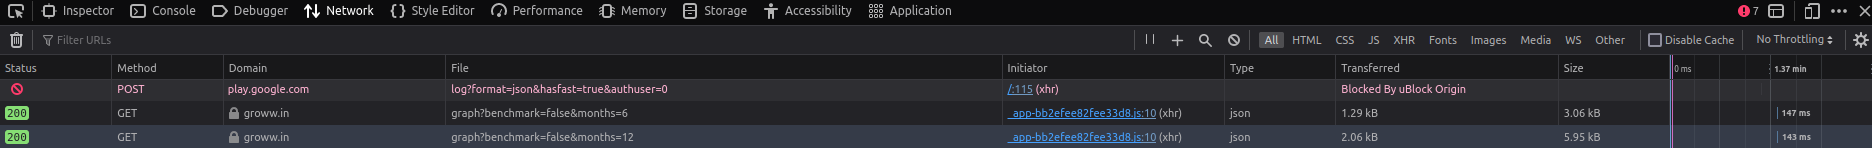

There it is. 

Now we can use the URL to pull the data for our custom time period. 

Let's look at 37 months, so that we can analyze the data between Jan 21-Dec 23

In [1]:
### Storing the URLs to dedicated variables

nippon='https://groww.in/v1/api/data/mf/web/v1/scheme/146513/graph?benchmark=false&months=37'
    
canera='https://groww.in/v1/api/data/mf/web/v1/scheme/146130/graph?benchmark=false&months=37'

MotNas='https://groww.in/v1/api/data/mf/web/v1/scheme/145552/graph?benchmark=false&months=37'

DSPNif='https://groww.in/v1/api/data/mf/web/v1/scheme/141877/graph?benchmark=false&months=37'

Let's write a function to pull and clean the data from these links

In [2]:
def growwscrape(link):
    import requests

    import pandas as pd



    url = link
    response = requests.get(url)
    js=response.json()
    
    ## Writing the json we got from the query into a pandas DataFrame
    df=pd.DataFrame(js['folio']['data'],columns=['Date','NAV'])
    df['Date']=pd.to_datetime(df['Date'], unit='ms')
    df=df.set_index('Date')
    
    ## Isolating the dates to the period we want to examine
    df=df.loc[(df.index>='2021-01-01')&(df.index<'2024-01-01')]
    
    return df

In [3]:
#Storing the data for the funds in these variables

nipp=growwscrape(nippon)
nipp.to_csv('nippon.csv')

can=growwscrape(canera)
can.to_csv('canera.csv')
Mot=growwscrape(MotNas)
Mot.to_csv('Motilal.csv')
DSP=growwscrape(DSPNif)
DSP.to_csv('DSP.csv')

Let's check if it worked by checking out one of them

In [4]:
nipp.head()

,NAV
Date,
2021-01-03 18:30:00,12.1839
2021-01-04 18:30:00,12.3505
2021-01-05 18:30:00,12.4173
2021-01-06 18:30:00,12.4678
2021-01-07 18:30:00,12.5564


In [5]:
nipp.tail()

,NAV
Date,
2023-12-25 18:30:00,19.5391
2023-12-26 18:30:00,19.6320
2023-12-27 18:30:00,19.7195
2023-12-28 18:30:00,19.8806
2023-12-31 18:30:00,19.9074


## Examining the Data

Let us take a look at the funds to see how they have performed over the years

In [6]:
### A function to plot a graph of the NAV of the funds during our period of interest

def fundplot(dataframe,fund_name):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(nipp.index,nipp['NAV'])
    labels = ax.get_xticklabels()
    plt.setp(labels, 
             rotation=45, 
             horizontalalignment='right')
    ax.set(xlabel='Date', 
           ylabel='NAV',
           title=fund_name)
    ax.yaxis.set_major_formatter('₹{x:1.0f}')
    plt.show()
    
    ## Calculating the returns of a one time investment at the beginning of our period of interest
    startingprice=dataframe.NAV[0]
    endingprice=dataframe.NAV[-1]
    change=round(((endingprice-startingprice)/startingprice)*100,0)
    print(f'1 Jan 2021: ₹{startingprice}')
    print(f'31 Dec 2023: ₹{endingprice}')
    print(f'NAV Change: ₹{change}%')

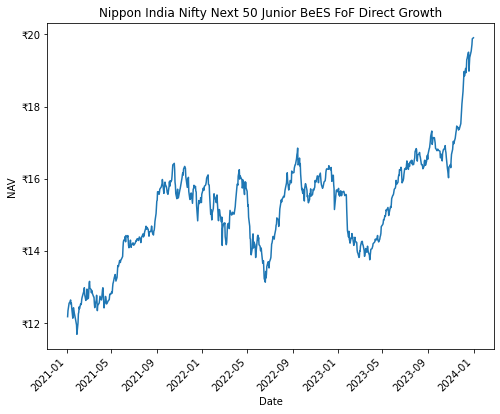

1 Jan 2021: ₹12.1839
31 Dec 2023: ₹19.9074
NAV Change: ₹63.0%


In [7]:
fundplot(nipp,'Nippon India Nifty Next 50 Junior BeES FoF Direct Growth')

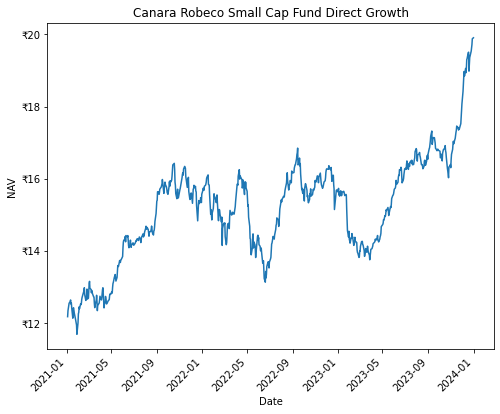

1 Jan 2021: ₹14.3
31 Dec 2023: ₹35.51
NAV Change: ₹148.0%


In [8]:
fundplot(can,'Canara Robeco Small Cap Fund Direct Growth')

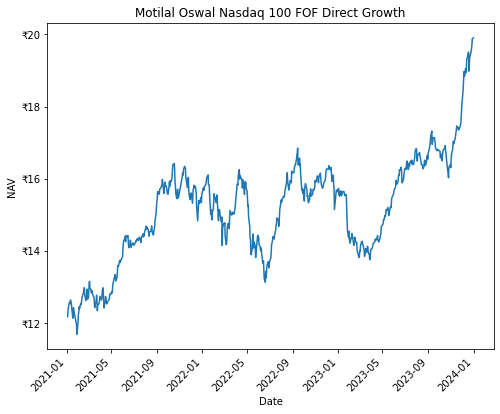

1 Jan 2021: ₹20.0627
31 Dec 2023: ₹29.2513
NAV Change: ₹46.0%


In [9]:
fundplot(Mot,'Motilal Oswal Nasdaq 100 FOF Direct Growth')

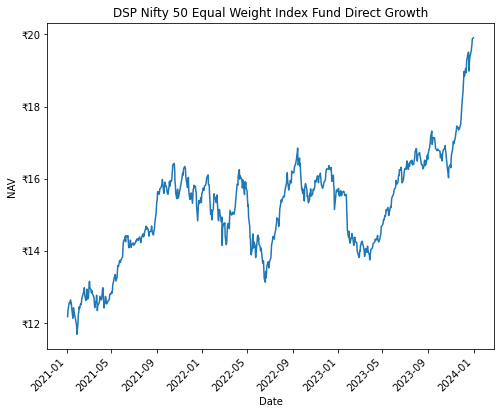

1 Jan 2021: ₹11.8967
31 Dec 2023: ₹22.0465
NAV Change: ₹85.0%


In [10]:
fundplot(DSP,'DSP Nifty 50 Equal Weight Index Fund Direct Growth')

## Data Analysis

Now we have an idea about the changes in the NAV of the funds over the last 3 years. Now let us see if there are any major differences in returns between SIPs with varying frequencies. 

In [11]:
# A function to calculate returns from a monthly or a weekly SIP plan, and to compare them

def sipcomparer(amount,dataframe,fund_name):

    import matplotlib.pyplot as plt
    
    #Creating a new column for week number and month number for the requisite periods
    dataframe['month']=dataframe.index.strftime('%Y-%m')
    dataframe['week']=dataframe.index.strftime('%Y-%U')
    
    #The Investments will be made on the first day of each week
    weekly=dataframe.groupby('week').first()
    weekly['units']=(amount/weekly['NAV'].count())/weekly['NAV']
    weeklyunits=weekly['units'].sum().round(0)
    weeklyprice=round(weeklyunits*dataframe['NAV'][-1],0)
    
    #The investment will be made on the first day of each month
    monthly=dataframe.groupby('month').first()
    monthly['units']=(amount/monthly['NAV'].count())/monthly['NAV']
    monthlyunits=monthly['units'].sum().round(0)
    monthlyprice=round(monthlyunits*dataframe['NAV'][-1],0)
    
    x_axis=['Monthly SIP','Weekly SIP']
    clr=['purple','pink']
    fig, ax = plt.subplots(figsize=(4, 7))
    ax.bar(x_axis,[monthlyprice,weeklyprice],width=.4,color=clr)
    labels = ax.get_xticklabels()
    
    #Plotting a bar chart to showcase the differences between the two investments
    ax.set(xlabel='Investment Frequency', 
           ylabel='Total Investment Value',
           title=fund_name)
    ax.yaxis.set_major_formatter('₹{x:1.0f}')
    plt.show()
    
    
    difference=abs(weeklyprice-monthlyprice)
    print(f'Weekly Investment Total=₹{weeklyprice}')
    print(f'Monthly Investment Total=₹{monthlyprice}')
    
    if monthlyunits>weeklyunits:
        print(f"Monthly SIP had higher returns by ₹{difference}")
    elif monthlyunits==weeklyunits:
        print(f'Their returns were equal')
       
    else:
         print(f'Weekly SIP had higher returns by ₹{difference}')

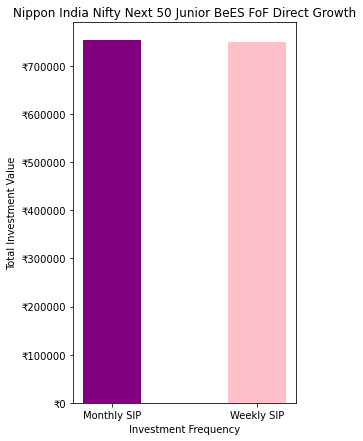

Weekly Investment Total=₹749534.0
Monthly Investment Total=₹752739.0
Monthly SIP had higher returns by ₹3205.0


In [12]:
sipcomparer(565200,nipp,'Nippon India Nifty Next 50 Junior BeES FoF Direct Growth')

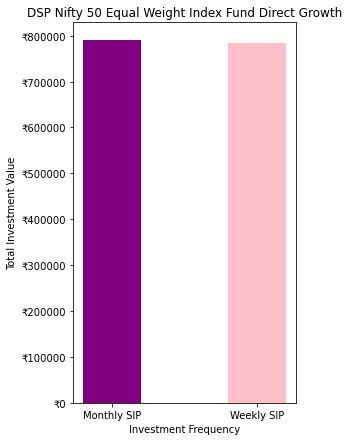

Weekly Investment Total=₹785142.0
Monthly Investment Total=₹789750.0
Monthly SIP had higher returns by ₹4608.0


In [13]:
sipcomparer(565200,DSP,'DSP Nifty 50 Equal Weight Index Fund Direct Growth')

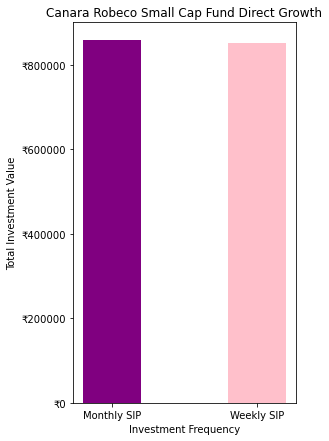

Weekly Investment Total=₹851175.0
Monthly Investment Total=₹857886.0
Monthly SIP had higher returns by ₹6711.0


In [14]:
sipcomparer(565200,can, 'Canara Robeco Small Cap Fund Direct Growth')

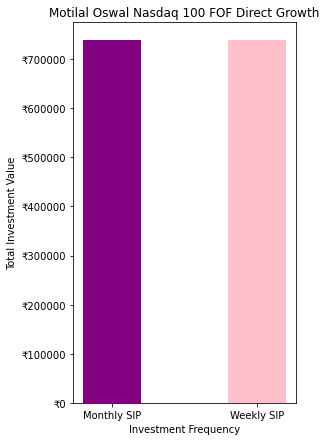

Weekly Investment Total=₹738303.0
Monthly Investment Total=₹738127.0
Weekly SIP had higher returns by ₹176.0


In [15]:
sipcomparer(565200,Mot,'Motilal Oswal Nasdaq 100 FOF Direct Growth')

## Conclusion

Even though the funds showed some differences in returns based on the investment frequency, they were too minor to be significant. 

And while 3 funds had the Monthly SIP showing higher returns, in one of the cases, the weekly SIP had the higher return. 

So, it is evident that the investment frequency has no major bearing on the returns. 

Hence, I reccomend that people focus on investing regularly, rather than being too worried about the frequency of the investment. For most people, this would probably be the monthly frequency. 